In [21]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

# Suppresses warnings
# Warnings were noted prior to cleaning up the notebook, suppressing them are for aesthetics
import warnings
warnings.filterwarnings(action='ignore')

import time
import copy
import random
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from timeit import default_timer as timer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from imblearn import pipeline
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import TomekLinks
tf.compat.v1.disable_eager_execution()
# Initialise seed value - 42
seed = 42
random.seed(42)
tf.random.set_seed(seed)
np.random.seed(seed)
sns.set_style("whitegrid")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [2]:
#loading credit card fraud dataset to pandas datafame
credit=pd.read_csv('creditcard.csv')

In [3]:
#show the first 5 rows of the dataset
credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [48]:
#Generative Model Classes
class GAN(object):
    
    """ Invoke the methods in sequential order according to the scope, otherwise there would be errors. """
    
    def __init__(self, batches=2048, X_nodes=30, y_nodes=1, z_dims=100, X_name='X_data', z_name='z_prior', orig_loss_fn=True):
        
        # Initialise inputs
        self.batch_, self.X_node_, self.y_node_, self.z_dim_ = batches, X_nodes, y_nodes, z_dims
        self.original_loss_fn_ = orig_loss_fn
        
        # Initialise placeholders
        self.X_ = tf.compat.v1.placeholder(tf.float32, [None, self.X_node_], name= X_name)
        self.prior_z_ = tf.compat.v1.placeholder(tf.float32, [None, self.z_dim_], name= z_name)
        
        # Generator parameters
        self.gen_X_, self.gen_params_ = None, None
        
        # Discriminator parameters
        self.y_data_, self.gen_y_, self.dis_params_ = None, None, None
        
        # Optimisation parameters
        self.d_loss_, self.g_loss_, self.d_trainer_, self.g_trainer_ = None, None, None, None
        self.g2_, self.d2_, self.gen_d2_ = None, None, None
                  
    def generator(self, h1_nodes=500, h2_nodes=500):
        
        # Generator weights/biases
        g_h1 = {'weights': tf.Variable(xavier_init([self.z_dim_, h1_nodes], 'g_w1', tf.float32)),
                'biases': tf.Variable(tf.zeros(h1_nodes), name='g_b1', dtype=tf.float32)}
        g_h2 = {'weights': tf.Variable(xavier_init([h1_nodes, h2_nodes], 'g_w2', tf.float32)),
                'biases': tf.Variable(tf.zeros([h2_nodes]), name='g_b2', dtype=tf.float32)}
        g_h3 = {'weights': tf.Variable(xavier_init([h2_nodes, self.X_node_], 'g_w3', tf.float32)),
                'biases': tf.Variable(tf.zeros([self.X_node_]), name='g_b3', dtype=tf.float32)}

        # Fully connect the layers
        g1 = tf.nn.leaky_relu(tf.matmul(self.prior_z_, g_h1['weights']) + g_h1['biases'])
        if self.original_loss_fn_:
            self.g2_ = tf.nn.leaky_relu(tf.matmul(g1, g_h2['weights']) + g_h2['biases'])
        else:
            self.g2_ = tf.matmul(g1, g_h2['weights']) + g_h2['biases']
#         g_out = tf.nn.sigmoid(tf.matmul(self.g2_, g_h3['weights']) + g_h3['biases'])
        g_out = tf.nn.tanh(tf.matmul(self.g2_, g_h3['weights']) + g_h3['biases'])

        # Generate fake x's with from output layer of generator
        self.gen_X_ = g_out

        # List of 'var_list' for generator trainer to optimise
        self.gen_params_ = [g_h1['weights'], g_h1['biases'],
                           g_h2['weights'], g_h2['biases'],
                           g_h3['weights'], g_h3['biases']]
        
    def discriminator(self, h1_nodes=500, h2_nodes=500):
        
        ## Discriminator weights/biases ##
        d_h1 = {'weights': tf.Variable(xavier_init([self.X_node_, h1_nodes], 'd_w1', tf.float32)),
                'biases': tf.Variable(tf.zeros([h1_nodes]), name='d_b1', dtype=tf.float32)}
        d_h2 = {'weights': tf.Variable(xavier_init([h1_nodes, h2_nodes], 'd_w2', tf.float32)),
                'biases': tf.Variable(tf.zeros([h2_nodes]), name='d_b2', dtype=tf.float32)}
        d_h3 = {'weights': tf.Variable(xavier_init([h2_nodes, self.y_node_], 'd_w3', tf.float32)),
                'biases': tf.Variable(tf.zeros([self.y_node_]), name='d_b3', dtype=tf.float32)}
            # Output shape has 2 features; Shape: [batch(real) + batch(gen.), 2]
            
        # Real data output
        # Fully connect the layers
        d1 = tf.nn.leaky_relu(tf.matmul(self.X_, d_h1['weights']) + d_h1['biases'])
        if self.original_loss_fn_:
            self.d2_ = tf.nn.leaky_relu(tf.matmul(d1, d_h2['weights']) + d_h2['biases']) # Originally acitvated with sigmoid
        else:
            self.d2_ = tf.matmul(d1, d_h2['weights']) + d_h2['biases']
        d_out = tf.nn.sigmoid(tf.matmul(self.d2_, d_h3['weights']) + d_h3['biases'])
        
        self.y_data_ = d_out # 'y_data' == D(x)
        
        # Generated data output
        # Fully connect the layers
        gen_d1 = tf.nn.leaky_relu(tf.matmul(self.gen_X_, d_h1['weights']) + d_h1['biases'])
        if self.original_loss_fn_:
            self.gen_d2_ = tf.nn.leaky_relu(tf.matmul(gen_d1, d_h2['weights']) + d_h2['biases']) # Originally acitvated with sigmoid
        else:
            self.gen_d2_ = tf.matmul(gen_d1, d_h2['weights']) + d_h2['biases']
        gen_d_out = tf.nn.sigmoid(tf.matmul(self.gen_d2_, d_h3['weights']) + d_h3['biases'])
        
        self.gen_y_ = gen_d_out # 'gen_y' == D[G(z)]
        
        ## List of 'var_list' for discriminator trainer to optimise ##
        self.dis_params_ = [d_h1['weights'], d_h1['biases'],
                           d_h2['weights'], d_h2['biases'],
                           d_h3['weights'], d_h3['biases']]

    def optimise(self, train_step=0.0001):
        
        if self.original_loss_fn_:
            # Losses
            # tf.reduce_mean() to compute the average losses
            self.d_loss_ = - tf.reduce_mean(tf.math.log(self.y_data_) + tf.math.log(1.0 - self.gen_y_))
#             self.g_loss_ = tf.reduce_mean(tf.math.log(1.0 - self.gen_y_))
            self.g_loss_ = - tf.reduce_mean(tf.math.log(self.gen_y_))
                # Alternate generator loss function optimisation: - tf.reduce_mean(tf.log(self.gen_y_))
                
        else:
            # Alternate loss function: cross-entropy losses
            D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.d2_, labels=tf.ones_like(self.d2_)))
            D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.gen_d2_, labels=tf.zeros_like(self.gen_d2_)))
            self.d_loss_ = D_loss_real + D_loss_fake
            self.g_loss_ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.g2_, labels=tf.ones_like(self.g2_)))
 
        # Optimiser
        # optimiser = tf.train.AdadeltaOptimizer(learning_rate=1.0)
        optimiser = tf.optimizers.Adam(learning_rate=train_step)
        
        # Optimisation Trainers
#         self.d_trainer_ = optimiser.minimize(self.d_loss_, var_list=self.dis_params_)
#         self.g_trainer_ = optimiser.minimize(self.g_loss_, var_list=self.gen_params_)     
        self.d_trainer_ = tf.optimizers.SGD(learning_rate=train_step).minimize(self.d_loss_, var_list=self.dis_params_)
        self.g_trainer_ = tf.optimizers.Adam(learning_rate=train_step).minimize(self.g_loss_, var_list=self.gen_params_)



class WassersteinGAN(object):
    
    """ Invoke the methods in sequential order according to the scope, otherwise there would be errors. """
    
    def __init__(self, batches=2048, X_nodes=29, y_nodes=1, z_dims=100, X_name='X_data', z_name='z_prior', orig_loss_fn=True):
        
        # Initialise inputs
        self.batch_, self.X_node_, self.y_node_, self.z_dim_ = batches, X_nodes, y_nodes, z_dims
        self.original_loss_fn_ = orig_loss_fn
        
        # Initialise placeholders
        self.X_ = tf.compat.v1.placeholder(tf.float32, [None, self.X_node_], name=X_name)
        self.prior_z_ = tf.compat.v1.placeholder(tf.float32, [None, self.z_dim_], name=z_name)
        
        # Generator parameters
        self.gen_X_, self.gen_params_ = None, None
        
        # Discriminator parameters
        self.y_data_, self.gen_y_, self.dis_params_ = None, None, None
        
        # Optimisation parameters
        self.clip_dis_, self.d_loss_, self.g_loss_, self.d_trainer_, self.g_trainer_ = None, None, None, None, None
        self.g2_, self.d2_, self.gen_d2_ = None, None, None
                  
    def generator(self, h1_nodes=500, h2_nodes=500):
        
        # Generator weights/biases
        g_h1 = {'weights': tf.Variable(xavier_init([self.z_dim_, h1_nodes], 'g_w1', tf.float32)),
                'biases': tf.Variable(tf.zeros(h1_nodes), name='g_b1', dtype=tf.float32)}
        g_h2 = {'weights': tf.Variable(xavier_init([h1_nodes, h2_nodes], 'g_w2', tf.float32)),
                'biases': tf.Variable(tf.zeros([h2_nodes]), name='g_b2', dtype=tf.float32)}
        g_h3 = {'weights': tf.Variable(xavier_init([h2_nodes, self.X_node_], 'g_w3', tf.float32)),
                'biases': tf.Variable(tf.zeros([self.X_node_]), name='g_b3', dtype=tf.float32)}

        # Fully connect the layers
        g1 = tf.nn.leaky_relu(tf.matmul(self.prior_z_, g_h1['weights']) + g_h1['biases'])
        if self.original_loss_fn_:
            self.g2_ = tf.nn.leaky_relu(tf.matmul(g1, g_h2['weights']) + g_h2['biases'])
        else:
            self.g2_ = tf.matmul(g1, g_h2['weights']) + g_h2['biases']
        g_out = tf.nn.tanh(tf.matmul(self.g2_, g_h3['weights']) + g_h3['biases'])
        # Activation changed from sigmoid to tanh
        
        # Generate fake x's with from output layer of generator
        self.gen_X_ = g_out

        # List of 'var_list' for generator trainer to optimise
        self.gen_params_ = [g_h1['weights'], g_h1['biases'],
                           g_h2['weights'], g_h2['biases'],
                           g_h3['weights'], g_h3['biases']]
        
    def discriminator(self, h1_nodes=500, h2_nodes=500):
        
        ## Discriminator weights/biases ##
        d_h1 = {'weights': tf.Variable(xavier_init([self.X_node_, h1_nodes], 'd_w1', tf.float32)),
                'biases': tf.Variable(tf.zeros([h1_nodes]), name='d_b1', dtype=tf.float32)}
        d_h2 = {'weights': tf.Variable(xavier_init([h1_nodes, h2_nodes], 'd_w2', tf.float32)),
                'biases': tf.Variable(tf.zeros([h2_nodes]), name='d_b2', dtype=tf.float32)}
        d_h3 = {'weights': tf.Variable(xavier_init([h2_nodes, self.y_node_], 'd_w3', tf.float32)),
                'biases': tf.Variable(tf.zeros([self.y_node_]), name='d_b3', dtype=tf.float32)}
            # Output shape has 2 features; Shape: [batch(real) + batch(gen.), 2]
            
        # Real data output
        # Fully connect the layers
        d1 = tf.nn.leaky_relu(tf.matmul(self.X_, d_h1['weights']) + d_h1['biases'])
        if self.original_loss_fn_:
            self.d2_ = tf.nn.leaky_relu(tf.matmul(d1, d_h2['weights']) + d_h2['biases']) # Originally acitvated with sigmoid
        else:
            self.d2_ = tf.matmul(d1, d_h2['weights']) + d_h2['biases']
        d_out = tf.nn.sigmoid(tf.matmul(self.d2_, d_h3['weights']) + d_h3['biases'])
        
        self.y_data_ = d_out # 'y_data' == D(x)
        
        # Generated data output
        # Fully connect the layers
        gen_d1 = tf.nn.leaky_relu(tf.matmul(self.gen_X_, d_h1['weights']) + d_h1['biases'])
        if self.original_loss_fn_:
            self.gen_d2_ = tf.nn.leaky_relu(tf.matmul(gen_d1, d_h2['weights']) + d_h2['biases']) # Originally acitvated with sigmoid
        else:
            self.gen_d2_ = tf.matmul(gen_d1, d_h2['weights']) + d_h2['biases']
        gen_d_out = tf.nn.sigmoid(tf.matmul(self.gen_d2_, d_h3['weights']) + d_h3['biases'])
        
        self.gen_y_ = gen_d_out # 'gen_y' == D[G(z)]
        
        ## List of 'var_list' for discriminator trainer to optimise ##
        self.dis_params_ = [d_h1['weights'], d_h1['biases'],
                           d_h2['weights'], d_h2['biases'],
                           d_h3['weights'], d_h3['biases']]
        
        # Clipping of discriminator
        self.clip_dis_ = [param.assign(tf.clip_by_value(param, -0.05, 0.05)) for param in self.dis_params_]

    def optimise(self, train_step=0.0001):
        
        if self.original_loss_fn_:
            # Losses
            # tf.reduce_mean() to compute the average losses
            self.d_loss_ = - tf.reduce_mean(tf.math.log(self.y_data_) + tf.math.log(1.0 - self.gen_y_))
#             self.g_loss_ = tf.reduce_mean(tf.math.log(1.0 - self.gen_y_))
            self.g_loss_ = - tf.reduce_mean(tf.math.log(self.gen_y_))
                # Alternate generator loss function optimisation to avoid vanishing gradients: - tf.reduce_mean(tf.log(self.gen_y_))
        
        else:     
            # Alternate loss function: cross-entropy losses
            D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.d2_, labels=tf.ones_like(self.d2_)))
            D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.gen_d2_, labels=tf.zeros_like(self.gen_d2_)))
            self.d_loss_ = D_loss_real + D_loss_fake
            self.g_loss_ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.g2_, labels=tf.ones_like(self.g2_)))
 
        # Optimiser
        optimiser = tf.train.RMSPropOptimizer(learning_rate=train_step)
        
        # Optimisation Trainers
#         self.d_trainer_ = optimiser.minimize(self.d_loss_, var_list=self.dis_params_)
#         self.g_trainer_ = optimiser.minimize(self.g_loss_, var_list=self.gen_params_)
        self.d_trainer_ = tf.optimizers.SGD(learning_rate=train_step)#.minimize(self.d_loss_, var_list=self.dis_params_)
        self.g_trainer_ = tf.optimizers.Adam(learning_rate=train_step)#.minimize(self.g_loss_, var_list=self.gen_params_)
     

In [5]:
#checking for missing value
credit.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [25]:
#Functions defined
def uniform_draw_feat_class(data_df, target_name, draw_size):
    """ Sample out 1 particular class out of the full data uniformly in a predefined sample size,
    segregate pandas dataframe into their respective target classes. """
    
    # Break down full dataset into their respective classes
    target_class_dfs = {}
    n_classes = data_df[target_name].unique()
    
    for unique_class in n_classes:
        # Store each segregated class dataframes as dictionary
        class_i_df = data_df[data_df[target_name] == unique_class]
        class_i_df = (class_i_df.reset_index()).drop(columns=['index'])
        target_class_dfs[unique_class] = class_i_df
        
    # Obtain uniform samples of size 'draw_size' and store as dictionary
    uniform_class_sample_draws = {}
    
    # Pandas df. sampling default None equivalently uniform draws
    for unique_class in n_classes:
        unif_samples = target_class_dfs[unique_class].sample(n=draw_size, replace=True)
        sample_df = pd.DataFrame(unif_samples, columns=data_df.columns)    
        uniform_class_sample_draws[unique_class] = unif_samples
    
    # Returns dictionary of pandas dataframes, split into respective classes
    return uniform_class_sample_draws

def xavier_init(size, label, data_type):
    """ For usage in tensorflow neural nets weights initialisation per layer.
    Helps resolve issue of overfitting to data. """
    
    tf.random.set_seed(42)
    in_dim = size[0]; out_dim = size[1]
    xavier_stddev = 1. / tf.sqrt((in_dim + out_dim) / 2.)
    return tf.random.normal(shape=size, stddev=xavier_stddev, name=label, dtype=data_type)

def steady_epoch(loss_lst, num_epochs_ran, sd_fluc_pct=0.15, scan_frame=225, stab_fn=min):   
    """ 
    FOR THE PURPOSE OF FINDING A FRAME OF EPOCHS WHERE THE LOSSES HAS STABILISED WITHIN SPECIFIED PERCENTAGE OF 
    1SD OF LOSSES FOR ALL EPOCHS EXECUTED
    
    DEFAULT FRAME OF EPOCHS WHERE LOSS IS CONSIDERED STEADY IS 225, FLUCTUATING WITHIN +/- 15% OF 1 S.D. OF THE LOSSES
    
    [EXAMPLE - 5% OF S.D., 5% OF TOTAL EPOCHS RAN]
    Obtain minimum of losses and its corresponding 1 s.d. of loss of the given array of losses
    Do for a list of losses
        For some 5% out of all epochs ran
            if that particular 5% of epochs have losses each within +/-5% of the minimum loss,
                Epoch frame chosen as steady epoch-period
                Else return 'no steady epoch-periods found'; break
        Return frame of epochs found 
    """
    # Obtain minimum and s.d. value of the losses for all epochs
    loss_1sd = np.std(loss_lst)
    stab_fn_loss = stab_fn(loss_lst)

    epoch_frame_start = 0
    epoch_frame_end = epoch_frame_start + scan_frame
    
    # Return nothing in the event no frame of losses are found to have steady losses
    steady_frame=None
    
    # For loop termination
    exit_loop = True
    while exit_loop:

        # Reset counter when one of the epoch is not within +/-'sd_fluc_pct'% of minimum losses
        counter_5pct = 0

        for epoch in range(epoch_frame_start, epoch_frame_end, 1):
            if (loss_lst[epoch] > stab_fn_loss and loss_lst[epoch] <= (stab_fn_loss + sd_fluc_pct*loss_1sd)) \
            or (loss_lst[epoch] < stab_fn_loss and loss_lst[epoch] >= (stab_fn_loss - sd_fluc_pct*loss_1sd)):
                
                # Increase counter progressively until all (225) epochs in 'scan_frame' are within specified tolerance
                counter_5pct += 1

                # When (225) epochs are within +/-'sd_fluc_pct'% of minimal loss, flag the (225th) final epoch
                if counter_5pct == scan_frame:
                    print('Steady epoch frame found at epoch {} as final'.format(epoch_frame_end))
                    
                    # Return numpy array of epoch numbers within (225) specified range
                    steady_frame = np.linspace(start=(epoch_frame_end-scan_frame+1), stop=epoch_frame_end, num=scan_frame)
                    exit_loop = False
                    break           
            else:
                break

        # When a frame of 225 epochs within +/-'sd_fluc_pct'% of minimum losses is not found,
            # shift to next frame by 1 epoch
        epoch_frame_start += 1
        epoch_frame_end += 1

        if epoch_frame_end > num_epochs_ran:
            print('No steady epoch frame found!')
            break

    return steady_frame
     


In [7]:

### Load credit card data and preprocessing ###


# Convert data into 'mini-batchable' numpy NORMAL arrays, drop 'Time'
credit_X = credit.drop(labels=['Time','Class'], axis='columns')
credit_y = credit['Class'].to_numpy()

# Train-test split data: 75/25
X_train, X_test, y_train, y_test = train_test_split(credit_X, credit_y, test_size=0.25, random_state=seed)

In [8]:

### Overview of data in 'credit' ###

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('max_info_columns', 1000)
pd.set_option('max_info_rows', 1000)

# Dtype; checking for nulls
print(credit.info(), '\n')

# Descriptive statistics
print(credit.describe(include='all'), '\n')

# Validate only fraud and non-fraud classes
print(credit['Class'].value_counts(), '\n')

# 1st 5 rows
credit.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Time    float64
 1   V1      float64
 2   V2      float64
 3   V3      float64
 4   V4      float64
 5   V5      float64
 6   V6      float64
 7   V7      float64
 8   V8      float64
 9   V9      float64
 10  V10     float64
 11  V11     float64
 12  V12     float64
 13  V13     float64
 14  V14     float64
 15  V15     float64
 16  V16     float64
 17  V17     float64
 18  V18     float64
 19  V19     float64
 20  V20     float64
 21  V21     float64
 22  V22     float64
 23  V23     float64
 24  V24     float64
 25  V25     float64
 26  V26     float64
 27  V27     float64
 28  V28     float64
 29  Amount  float64
 30  Class   int64  
dtypes: float64(30), int64(1)
memory usage: 67.4 MB
None 

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.84807

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
# Train test split as how data was done earlier
X_amt_tr, X_amt_te, y_amt_tr, y_amt_te = train_test_split(credit.drop(columns=['Class']).to_numpy(), credit['Class'].to_numpy(), 
                                                          test_size=0.25, random_state=42)

# Create dataframes
amt_tr = np.concatenate((X_amt_tr, y_amt_tr.reshape(-1, 1)), axis=1)
amt_tr_df = pd.DataFrame(amt_tr, columns=credit.columns)
amt_te = np.concatenate((X_amt_te, y_amt_te.reshape(-1, 1)), axis=1)
amt_te_df = pd.DataFrame(amt_te, columns=credit.columns)

# Training Set Fraud 'Amount' Sum
tl_tr_fraud_amt = amt_tr_df[amt_tr_df['Class'] == 1]['Amount'].sum()
# Test Set Fraud 'Amount' Sum
tl_te_fraud_amt = amt_te_df[amt_te_df['Class'] == 1]['Amount'].sum()
print('Total "Amount" in training set: {}'.format(np.round(tl_tr_fraud_amt, 2),np.round(tl_te_fraud_amt, 2)))
     

Total "Amount" in training set: 42513.46


In [10]:
# Labels
X_cols = list(credit.drop(labels=['Time', 'Class'], axis='columns').columns)
y_cols = credit[['Class']].columns
target_names = credit['Class'].map(lambda x: 'Non-Fraud' if x==0 else 'Fraud').unique()

# Training data as dataframe
X_train_df = pd.DataFrame(X_train, columns=X_cols)
X_train_df['Amount'] = StandardScaler().fit_transform(X_train_df['Amount'].to_numpy().reshape(-1, 1))
X_train_df = X_train_df.reset_index().drop(columns=['index'])
y_train_df = pd.DataFrame(y_train, columns=y_cols)
# Full dataframe
train_df = pd.concat([X_train_df, y_train_df], join='outer', axis='columns')
# X, y as numpy array
X_train, y_train = X_train_df.to_numpy(), y_train_df.to_numpy()

# Test data as dataframe
X_test_df = pd.DataFrame(X_test, columns=X_cols)
X_test_df['Amount'] = StandardScaler().fit(X_train_df['Amount'].to_numpy().reshape(-1, 1)).transform(X_test_df['Amount'].to_numpy().reshape(-1, 1))
X_test_df = X_test_df.reset_index().drop(columns=['index'])
y_test_df = pd.DataFrame(y_test, columns=y_cols)
# Full dataframe
test_df = pd.concat([X_test_df, y_test_df], join='outer', axis='columns')
# X, y as numpy array
X_test, y_test = X_test_df.to_numpy(), y_test_df.to_numpy()

# Check number of frauds in both training and testing data
print('Number of frauds in training data: {} out of {} cases ({:.10f}% fraud)'.format(np.sum(y_train), y_train.shape[0], np.mean(y_train)*100))
print('Number of frauds in test data: {} out of {} cases ({:.10f}% fraud)'.format(np.sum(y_test), y_test.shape[0], np.mean(y_test)*100))

Number of frauds in training data: 379 out of 213605 cases (0.1774303036% fraud)
Number of frauds in test data: 113 out of 71202 cases (0.1587034072% fraud)


explained variance ratio (first two components): [0.12503723 0.10004168]


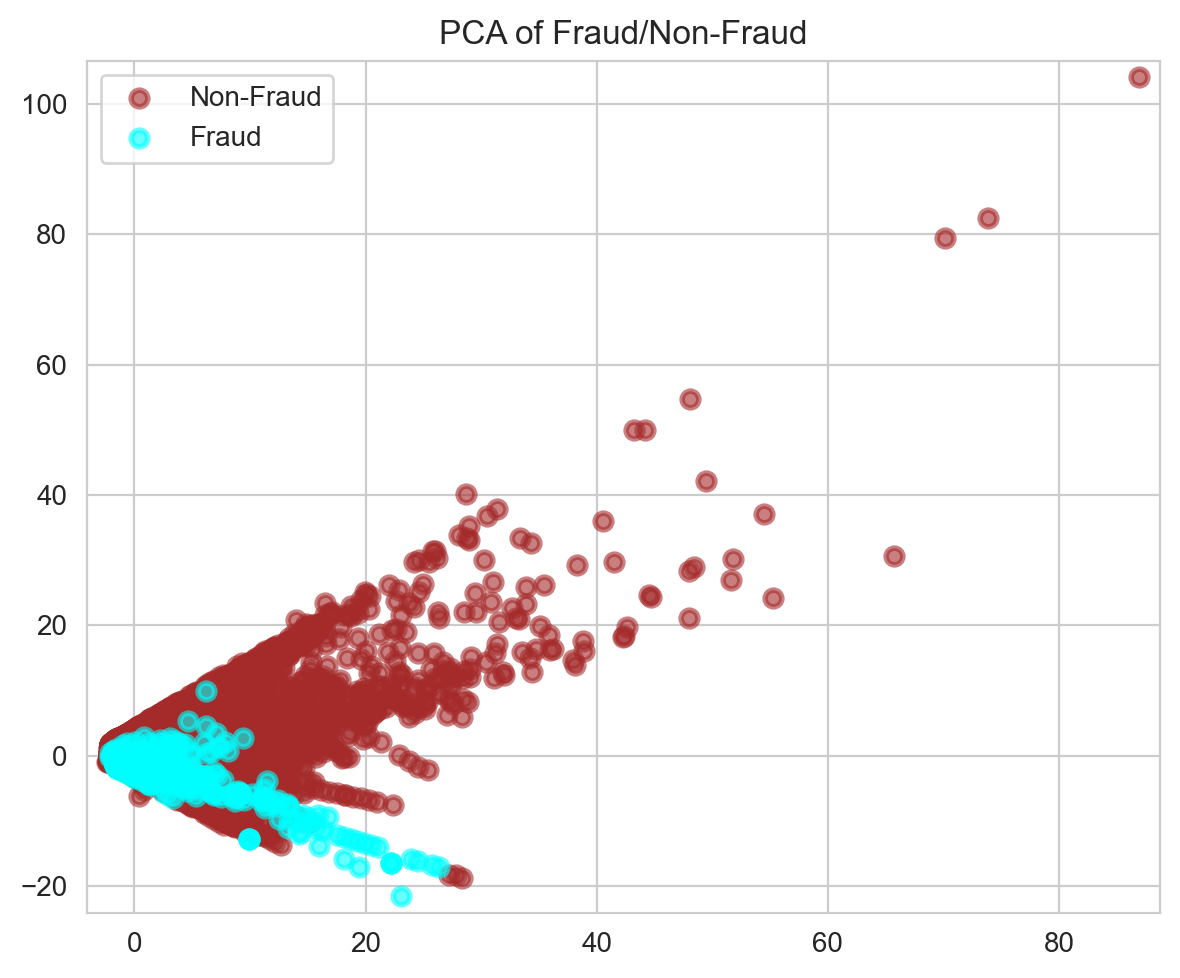

In [11]:

# 2-component PCA plot
    # PCA is sensitive to dimensional scales, thus the need to standardise matrix X
X_pca = copy.deepcopy(X_train)
y_pca = copy.deepcopy(y_train).reshape(-1, )

pca = PCA(n_components=2, random_state=seed)
X_r = pca.fit_transform(X_pca)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure(figsize=(6,5)); colors = ['brown', 'cyan']; lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y_pca == i, 0], X_r[y_pca == i, 1], color=color, alpha=.6, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of Fraud/Non-Fraud')
plt.tight_layout(); plt.margins(0.02)

In [12]:
# # Kernel Density Distribution subplots against target - 'Class'

# # Scatter subplots
# plt.figure(figsize=(20,18))
# for plot, feat in enumerate(X_cols):
    
#     plt.subplot(5, 6, (plot+1))
#     title = 'Fraud/Non-Fraud & ' + feat
    
#     # Normalise to visualise the differences in distributions
#     temp_df = pd.concat([X_train_df[[feat]], y_train_df], axis='columns')
#     temp_df.groupby(by='Class')[feat].plot(kind='kde', alpha=0.7, legend='best', lw=2.5)
#     plt.title(title)
#     plt.tight_layout(); plt.margins(0.02)
    
#     plt.show()
     

In [13]:
# Perform Wilcoxon Rank-Sum Test at 5% Level to determine feature relevance

# Keep results if needed later
wilcox_result = dict([])

for feat in X_cols:   
    temp_df = pd.concat([X_train_df[[feat]], y_train_df], axis='columns')
    
    # Draw 300 samples (only 379 fraud data in training set, attempt to draw close to the hilt)
    random.seed(42)
    fraud_wilcox = random.sample(list(temp_df[temp_df['Class']==1][feat]), k=300)
    nonfraud_wilcox = random.sample(list(temp_df[temp_df['Class']==0][feat]), k=300)
    
    rank_sums, p_val_wilcox = stats.wilcoxon(fraud_wilcox, nonfraud_wilcox)
    
    if p_val_wilcox > 0.05:
        wilcox_result[feat] = ('No_Diff', p_val_wilcox)
        print('Feature "{}" failed to be rejected at 5% level with p-value {:.10f}'.format(feat, p_val_wilcox))
    else:
        wilcox_result[feat] = ('Diff', p_val_wilcox)
    
# Rank-Sum Test determined differences in classes within feature
wilcox_feat = [feat for feat in wilcox_result.keys() if wilcox_result[feat][0] == 'Diff']
print('\n', 'Wilcoxon Rank-Sum Relevant Features: ', wilcox_feat)
print('Total number of features selected: {}'.format(len(wilcox_feat)))
     

Feature "V13" failed to be rejected at 5% level with p-value 0.0973465482
Feature "V15" failed to be rejected at 5% level with p-value 0.8092477538
Feature "V22" failed to be rejected at 5% level with p-value 0.3224055980
Feature "V23" failed to be rejected at 5% level with p-value 0.7011952304
Feature "V26" failed to be rejected at 5% level with p-value 0.5115929524
Feature "Amount" failed to be rejected at 5% level with p-value 0.9531649675

 Wilcoxon Rank-Sum Relevant Features:  ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V24', 'V25', 'V27', 'V28']
Total number of features selected: 23


In [14]:
unselected_feats = list(set(X_cols).difference(wilcox_feat))
print('Unselected features: {}'.format(unselected_feats))
     

Unselected features: ['V26', 'V15', 'Amount', 'V13', 'V23', 'V22']


In [15]:

# Obtain the top 6 most correlated wilcoxon-selected variables' to observe their scatter pair plot relations

# Check for high correlations
wilcox_corr = X_train_df.drop(columns=['V15', 'Amount', 'V13', 'V26', 'V22', 'V23']).corr().abs()
wilcox_corr_pdSr = wilcox_corr.unstack()
wilcox_corr_pdSr_sort = wilcox_corr_pdSr.sort_values(ascending=False).to_frame()

# Top 6 correlated variable pairs
wilcox_corr_pdSr_sort.iloc[23:35:2, :].rename(index=str, columns={0:'pearson_rho'})

,,pearson_rho
V7,V5,0.030143
V5,V6,0.016899
V7,V3,0.016640
V6,V7,0.016007
V1,V2,0.015015
V7,V1,0.012172


In [16]:
# Using default values except "penalty='elasticnet'"
# To preserve/remove meaningful/irrelevant Zfeatures without absolute purging
sgd_clf = SGDClassifier(penalty='elasticnet', random_state=seed, class_weight='balanced')

# Measure Start Time
start_time = time.time()

# Fit and obtain predictions
sgd_clf.fit(X_train_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).to_numpy(), y_train)
y_hat = sgd_clf.predict(X_test_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).to_numpy())

# Measure End Time
elapsed_time = time.time() - start_time
print('Time elapsed to train: ', elapsed_time)

pred_score = sgd_clf.score(X_test_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).to_numpy(), y_test)
print('Prediction Score: ', pred_score, '\n')
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_hat), '\n')
print('Classification Report:', '\n', classification_report_imbalanced(y_test, y_hat))

Time elapsed to train:  7.923961877822876
Prediction Score:  0.9646498693856914 

Confusion Matrix:  
 [[68580  2509]
 [    8   105]] 

Classification Report: 
                    pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.96      0.93      0.98      0.95      0.90     71089
          1       0.04      0.93      0.96      0.08      0.95      0.89       113

avg / total       1.00      0.96      0.93      0.98      0.95      0.90     71202



In [38]:
# General Parameters

# Inputs
gan_epochs = 6300
mini_bat = 5000 # Equivalently gan_fraudless/fraud.batch_

X_feats = len(wilcox_feat) # 30 features originally describing fraud/non-fraud; Equivalently gan_fraudless/fraud.X_node_
prior_z_dim = 100 # Draw 100 prior values to feed generator; Equivalently gan_fraudless/fraud.z_dim_

# Output
y_outputs = 1 # Equivalently gan_fraudless/fraud.y_node_

# Create GAN objects for fraud data
gan_fraud = GAN(batches=mini_bat, X_nodes=X_feats, y_nodes=y_outputs, z_dims=prior_z_dim)
gan_fraud.generator()
gan_fraud.discriminator()
gan_fraud.optimise()
     

In [62]:
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

# Measure Start Time
start_time = time.time()

### Training phase ###
init = tf.compat.v1.global_variables_initializer()

with tf.compat.v1.Session() as sess:
    sess.run(init)
    
    # Collect list of generator/discriminator losses
    gan_fraud_loss = []
    
    # Collect generated fraud data; Epoch as key, array as values
    gan_fraud_X = {}
    
    ## Execute training epochs ##
    for epoch in range(gan_epochs):
        
        # Feed X mini-batch
        # Drop following variable 'Time'
        split_df_dict = uniform_draw_feat_class(train_df, 'Class', mini_bat)
        fraud_X_mb = split_df_dict[1].drop(columns=['V15', 'V13', 'V23', 
                                                    'Amount', 'V26', 'V22', 'Class']).to_numpy().astype(np.float32)
    
        # Feed prior(z)
        fraud_z_sample = np.random.normal(size=[mini_bat, prior_z_dim]).astype(np.float32)
        
        # Minimise Losses
        _, fraud_dloss = sess.run([gan_fraud.d_trainer_, gan_fraud.d_loss_], 
                                      feed_dict={gan_fraud.X_: fraud_X_mb, 
                                                 gan_fraud.prior_z_: fraud_z_sample})
        _, fraud_gloss = sess.run([gan_fraud.g_trainer_, gan_fraud.g_loss_], 
                                      feed_dict={gan_fraud.X_: fraud_X_mb,
                                                 gan_fraud.prior_z_: fraud_z_sample})
        
        # Store losses per epoch
        gan_fraud_loss.append((fraud_dloss, fraud_gloss))
        
        if (epoch+1) % 100 == 0 or (epoch+1) == 1:
            # Print generator, discriminator losses for fraudless & fraud cases
            print('Epoch: {}'.format(epoch+1))
            print('Fraud generator loss: {} | discriminator loss: {}'.format(fraud_gloss, fraud_dloss), '\n')
        
        # Store generated data
        fraud_z_gen = np.random.normal(size=[mini_bat, prior_z_dim]).astype(np.float32)
        gan_fraud_X[epoch+1] = sess.run(gan_fraud.gen_X_, feed_dict={gan_fraud.prior_z_: fraud_z_gen})

# Measure End Time
elapsed_time = time.time() - start_time
print('Time elapsed to train: ', elapsed_time)
     

TypeError: Argument `fetch` = <keras.src.optimizers.sgd.SGD object at 0x000001AD1B09E5D0> has invalid type "SGD" must be a string or Tensor. (Can not convert a SGD into a Tensor or Operation.)

In [ ]:
# # Generate predictions on the test set
# y_pred = discriminator.predict(X_test)

# # Convert the predictions to binary (0 or 1)
# y_pred_binary = (y_pred > 0.5).astype(int)

# # Evaluate accuracy
# accuracy = accuracy_score(y_test, y_pred_binary)
# print(f"Accuracy: {accuracy}")

# # Evaluate precision
# precision = precision_score(y_test, y_pred_binary)
# print(f"Precision: {precision}")

# # Evaluate recall
# recall = recall_score(y_test, y_pred_binary)
# print(f"Recall: {recall}")

# # Evaluate F1 score
# f1 = f1_score(y_test, y_pred_binary)
# print(f"F1 Score: {f1}")

# # Display confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred_binary)
# print("Confusion Matrix:")
# print(conf_matrix)